In [134]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers


# The names will be the names of each column in our pandas DataFrame
names = ['age', 'sex', 'chestpaintype', 'restingbp', 'chol', 'fbs', 'restecg', 'maxhr', 'exang', 'oldpeak', 'slope']

# Read the CSV

data = pd.read_csv('/content/heart.csv')

# Considering only heart patients
data = data[data['HeartDisease'] != 0]

# # dropping the last column
# data = data.drop(columns=['HeartDisease'])

In [135]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
11,58,M,ATA,136,164,0,ST,99,Y,2.0,Flat,1
13,49,M,ASY,140,234,0,Normal,140,Y,1.0,Flat,1


In [136]:
# print the last twenty or so data points
data.loc[280:]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
281,49,M,ASY,150,222,0,Normal,122,N,2.0,Flat,1
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...
912,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1


In [137]:
# Data Imputation
DI = data.copy()

for Fi in DI.columns:
    if DI[Fi].isna().sum() > 0.6 * len(DI):
        # Drop the column if majority values are missing
        DI = DI.drop(columns=[Fi])
    elif DI[Fi].dtype == 'object' and DI[Fi].isna().sum() < 0.4 * len(DI):
        # Fill missing categorical values with the majority label
        DI[Fi].replace('?', DI[Fi].mode().iloc[0], inplace=True)  # Replace '?' with the majority label
        DI[Fi].fillna(DI[Fi].mode().iloc[0], inplace=True)  # Fill remaining missing categorical values
    elif DI[Fi].dtype != 'object' and DI[Fi].isna().sum() < 0.4 * len(DI):
        # Fill missing numeric values with the median
        DI[Fi].replace('?', DI[Fi].median(), inplace=True)  # Replace '?' with the median
        DI[Fi].fillna(DI[Fi].median(), inplace=True)  # Fill remaining missing numeric values


# # Update the original data with imputed values
data.update(DI)
# print the last twenty or so data points with imputed value
data.loc[280:]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
281,49,M,ASY,150,222,0,Normal,122,N,2.0,Flat,1
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...
912,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1


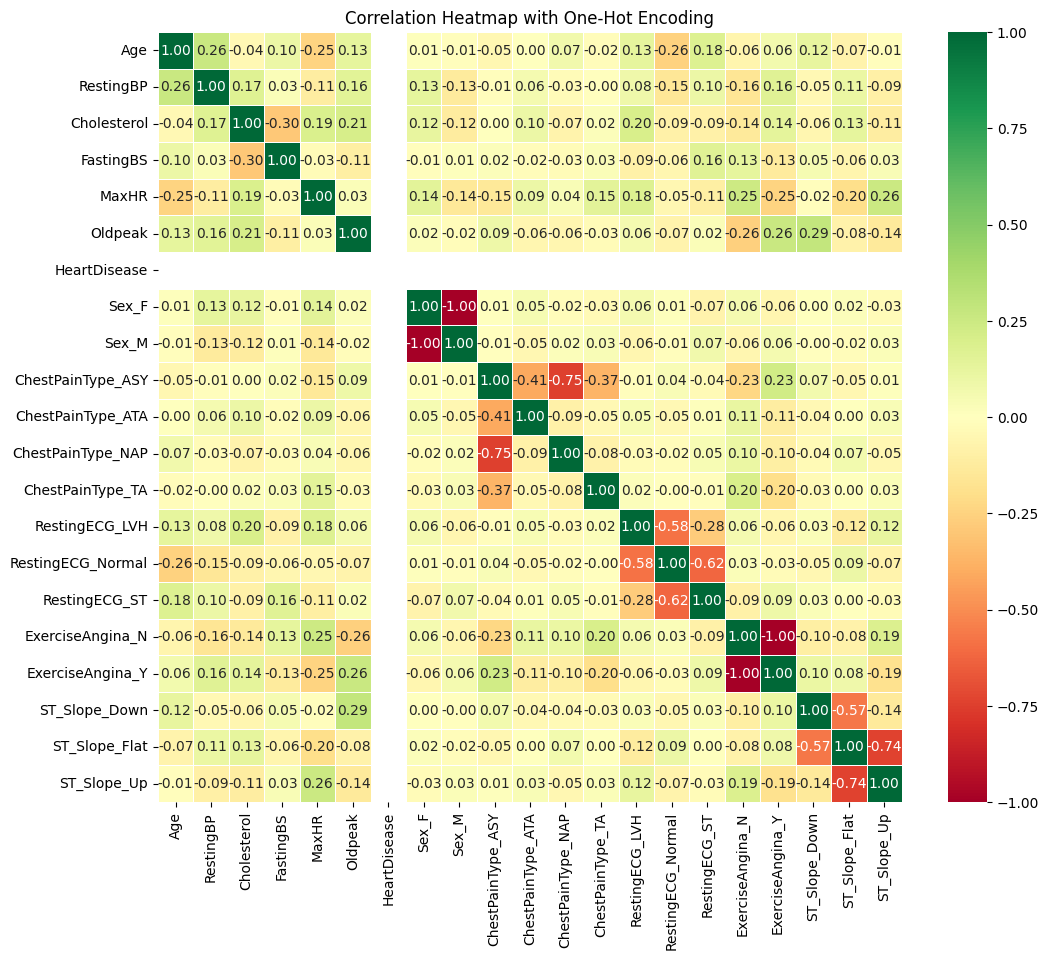

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame with both categorical and numerical features
# Apply one-hot encoding to categorical variables
df_encoded = pd.get_dummies(data)

# Generate correlation matrix
corr_matrix = df_encoded.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap with One-Hot Encoding")
plt.show()


In [139]:
# Dataset Stratification HoldOut
val_ratio = 0.275
IH, IN = train_test_split(data.index, test_size=val_ratio, stratify=data['ChestPainType'])

IVH_idx = data.loc[IH].sample(frac=val_ratio).index
ITH_idx = IH.drop(IVH_idx)

IVN_idx = data.loc[IN].sample(frac=val_ratio).index
ITN_idx = IN.drop(IVN_idx)


train_data = data.loc[ITH_idx.append(ITN_idx)]
validation_data = data.loc[IVH_idx.append(IVN_idx)]
num_rows_train = train_data.shape[0]
num_rows_validation = validation_data.shape[0]

print("Number of rows in train_data:", num_rows_train)
print("Number of rows in validation_data:", num_rows_validation)


Number of rows in train_data: 369
Number of rows in validation_data: 139


In [140]:
print(train_data['ChestPainType'].value_counts())
print(validation_data['ChestPainType'].value_counts())

ASY    287
NAP     52
ATA     17
TA      13
Name: ChestPainType, dtype: int64
ASY    105
NAP     20
ATA      7
TA       7
Name: ChestPainType, dtype: int64


In [141]:
# Define categorical features
categorical_features = ['Sex', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Convert categorical features to categorical type
train_data[categorical_features] = train_data[categorical_features].astype('category')

# Separate features and labels
X = train_data.drop('ChestPainType', axis=1)
y = train_data['ChestPainType']

# Convert categorical labels to numerical form
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=np.number))

# One-hot encode categorical features
X_categorical = pd.get_dummies(X[categorical_features])

# Concatenate scaled numerical features with one-hot encoded categorical features
X_final = np.concatenate([X_scaled, X_categorical], axis=1)

# Build the neural network model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_final.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(train_data['ChestPainType'].unique()), activation='softmax')  # Output layer with softmax activation for multiclass classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_final, y_encoded, epochs=100, batch_size=10, verbose=2)


Epoch 1/100
37/37 - 1s - loss: 1.0191 - accuracy: 0.6856 - 983ms/epoch - 27ms/step
Epoch 2/100
37/37 - 0s - loss: 0.7969 - accuracy: 0.7778 - 95ms/epoch - 3ms/step
Epoch 3/100
37/37 - 0s - loss: 0.7365 - accuracy: 0.7778 - 105ms/epoch - 3ms/step
Epoch 4/100
37/37 - 0s - loss: 0.7243 - accuracy: 0.7778 - 98ms/epoch - 3ms/step
Epoch 5/100
37/37 - 0s - loss: 0.6937 - accuracy: 0.7778 - 96ms/epoch - 3ms/step
Epoch 6/100
37/37 - 0s - loss: 0.6801 - accuracy: 0.7778 - 95ms/epoch - 3ms/step
Epoch 7/100
37/37 - 0s - loss: 0.6658 - accuracy: 0.7778 - 93ms/epoch - 3ms/step
Epoch 8/100
37/37 - 0s - loss: 0.6530 - accuracy: 0.7778 - 96ms/epoch - 3ms/step
Epoch 9/100
37/37 - 0s - loss: 0.6415 - accuracy: 0.7778 - 96ms/epoch - 3ms/step
Epoch 10/100
37/37 - 0s - loss: 0.6307 - accuracy: 0.7805 - 95ms/epoch - 3ms/step
Epoch 11/100
37/37 - 0s - loss: 0.6238 - accuracy: 0.7805 - 92ms/epoch - 2ms/step
Epoch 12/100
37/37 - 0s - loss: 0.6126 - accuracy: 0.7859 - 98ms/epoch - 3ms/step
Epoch 13/100
37/37 - 0

In [142]:
from tensorflow.keras.models import load_model

model = load_model('/content/multi_model.h5')

# Convert categorical features to categorical type
validation_data[categorical_features] = validation_data[categorical_features].astype('category')

# Separate features and labels
X_test = validation_data.drop('ChestPainType', axis=1)
y_test = validation_data['ChestPainType']

# Convert categorical labels to numerical form
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Standardize numerical features
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test.select_dtypes(include=np.number))

# One-hot encode categorical features
X_test_categorical = pd.get_dummies(X_test[categorical_features])

X_val_final = np.concatenate([X_test_scaled, X_test_categorical], axis=1)

y_val_encoded = label_encoder.transform(validation_data['ChestPainType'])
y_val_pred = np.argmax(model.predict(X_val_final), axis=1)
accuracy_val = accuracy_score(y_val_encoded, y_val_pred)
print(f"Validation Accuracy: {accuracy_val*100:.2f}%")


5/5 [==============================] - 0s 4ms/step
Validation Accuracy: 94.96%


In [143]:
from sklearn.metrics import f1_score, classification_report

# Assuming your model is a multi-class classification model

# Load the model
model = load_model('/content/multi_model.h5')

# ... (your data preparation code)

# Predictions
y_val_probabilities = model.predict(X_val_final)
y_val_pred = np.argmax(y_val_probabilities, axis=1)

# F1 Score
f1 = f1_score(y_val_encoded, y_val_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Classification Report
class_report = classification_report(y_val_encoded, y_val_pred)
print("Classification Report:")
print(class_report)


5/5 [==============================] - 0s 3ms/step
F1 Score: 0.9474
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       105
           1       0.86      0.86      0.86         7
           2       1.00      0.75      0.86        20
           3       1.00      0.86      0.92         7

    accuracy                           0.95       139
   macro avg       0.95      0.87      0.90       139
weighted avg       0.95      0.95      0.95       139



# Similar Underlying Condition:

# Both asymptomatic CAD and typical angina arise from the same underlying condition, which is the narrowing or blockage of coronary arteries that supply blood to the heart muscle.
# Lack of Obvious Symptoms in Asymptomatic Cases:

# Asymptomatic individuals with CAD do not experience the typical chest pain or discomfort associated with angina. This absence of overt symptoms makes it challenging to identify the presence of CAD without specific diagnostic tests.
# Need for Medical Evaluation:

# Differentiating between asymptomatic CAD and typical angina often requires a comprehensive medical evaluation. This may include a detailed patient history, physical examination, and diagnostic tests such as stress tests, imaging studies, or coronary angiography.
# Discovery through Screening:

# Asymptomatic CAD is sometimes discovered incidentally when individuals undergo medical screenings or tests for other reasons. Routine check-ups, cholesterol screenings, or electrocardiograms may reveal the presence of CAD even in the absence of symptoms.
# In summary, due to the shared underlying condition and the lack of apparent symptoms in asymptomatic cases, a thorough medical examination and appropriate diagnostic tests are essential for distinguishing between asymptomatic CAD and typical angina. This emphasizes the importance of regular health check-ups and screenings for individuals at risk of cardiovascular disease.

5/5 [==============================] - 0s 3ms/step
F1 Score: 0.9474
Classification Report:
{'ASY': {'precision': 0.9459459459459459, 'recall': 1.0, 'f1-score': 0.9722222222222222, 'support': 105}, 'ATA': {'precision': 0.8571428571428571, 'recall': 0.8571428571428571, 'f1-score': 0.8571428571428571, 'support': 7}, 'NAP': {'precision': 1.0, 'recall': 0.75, 'f1-score': 0.8571428571428571, 'support': 20}, 'TA': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 7}, 'accuracy': 0.9496402877697842, 'macro avg': {'precision': 0.9507722007722008, 'recall': 0.8660714285714286, 'f1-score': 0.9023962148962148, 'support': 139}, 'weighted avg': {'precision': 0.951973556290103, 'recall': 0.9496402877697842, 'f1-score': 0.9473937333649564, 'support': 139}}


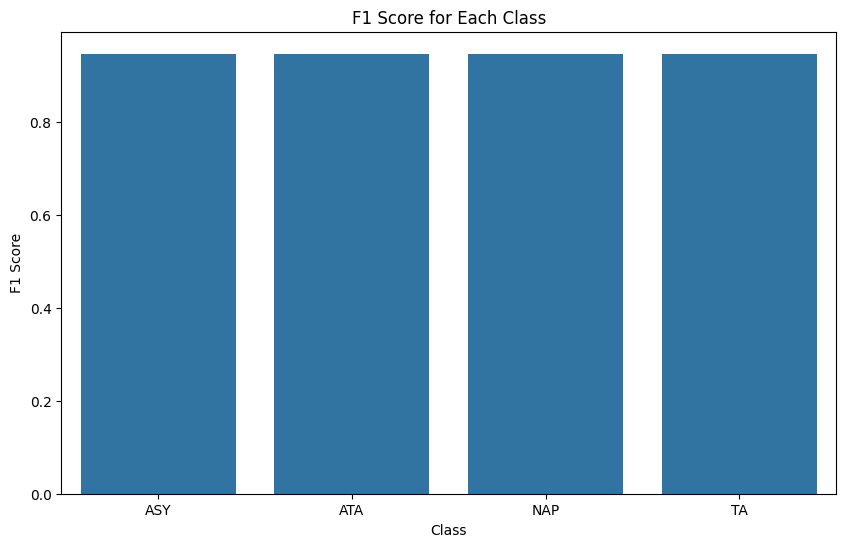

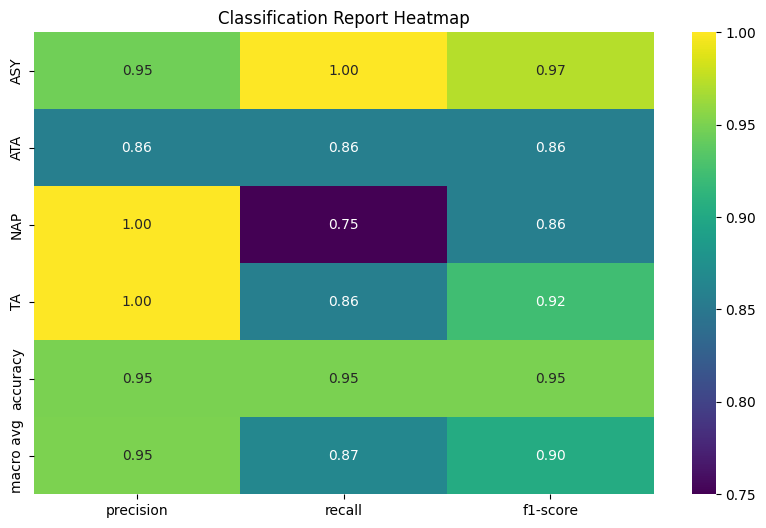

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your model is a multi-class classification model

# Load the model
model = load_model('/content/multi_model.h5')

# ... (your data preparation code)

# Predictions
y_val_probabilities = model.predict(X_val_final)
y_val_pred = np.argmax(y_val_probabilities, axis=1)

# F1 Score
f1 = f1_score(y_val_encoded, y_val_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Classification Report
class_report = classification_report(y_val_encoded, y_val_pred, target_names=label_encoder.classes_, output_dict=True)
print("Classification Report:")
print(class_report)

# Visualize F1 Scores
plt.figure(figsize=(10, 6))
sns.barplot(x=label_encoder.classes_, y=class_report['weighted avg']['f1-score'])
plt.title('F1 Score for Each Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.show()

# Visualize Classification Report using Heatmap
report_df = pd.DataFrame(class_report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='viridis', fmt=".2f")
plt.title('Classification Report Heatmap')
plt.show()


5/5 [==============================] - 0s 4ms/step


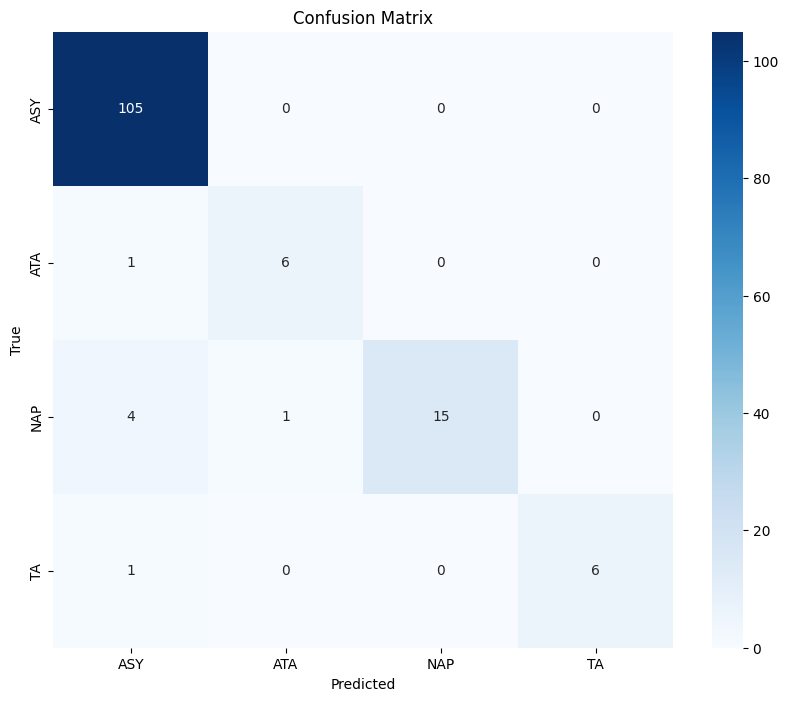

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your model is a multi-class classification model

# Load the model
model = load_model('/content/multi_model.h5')

# ... (your data preparation code)

# Predictions
y_val_probabilities = model.predict(X_val_final)
y_val_pred = np.argmax(y_val_probabilities, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val_encoded, y_val_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
